In [1]:
!pip install segyio
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import segyio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers # import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.models import Model
# from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model



In [5]:
seis = segyio.tools.cube('/content/drive/MyDrive/UTP_dGB_Documents/data/torosa-seismic/PloverTorosaSubArea_1015-1527_1500-3300_2-4_32bit.sgy')
eps = segyio.tools.cube('/content/drive/MyDrive/UTP_dGB_Documents/data/torosa-seismic/PloverTorosaSubArea_1015-1527_1500-3300_2-4_32bit_EPS.sgy')

In [6]:
print(seis.shape)

(513, 1801, 501)


In [7]:
seis_in = seis[42, :, :][:1792, 117:]
eps_out = eps[42, :, :][:1792, 117:]
print(seis_in.shape)

(1792, 384)


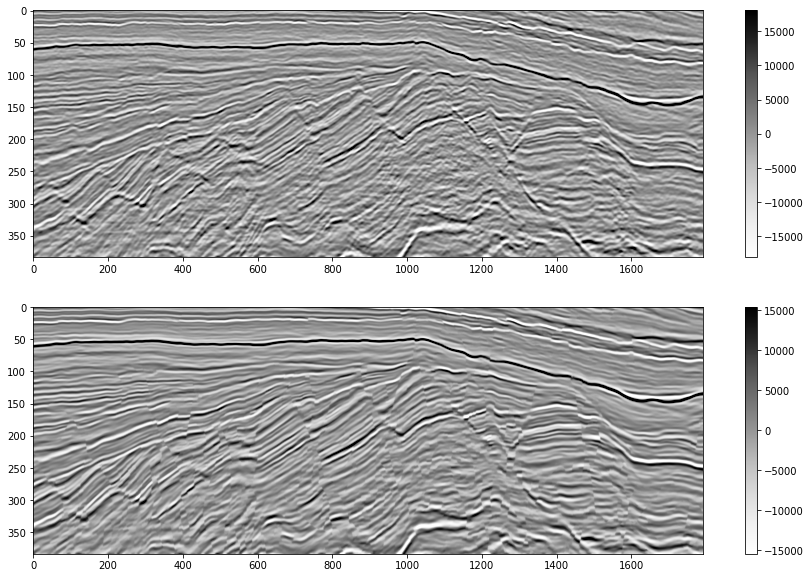

In [8]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
vs = np.percentile(seis_in, 99)
plt.imshow(seis_in.T, vmin=-vs, vmax=vs, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar()
plt.subplot(212)
ve = np.percentile(eps_out, 99)
plt.imshow(eps_out.T, vmin=-ve, vmax=ve, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar();

In [9]:
seis_patches = patchify(seis_in, (128, 128), step=128)
eps_patches = patchify(eps_out, (128, 128), step=128)

In [10]:
clean_data = np.reshape(eps_patches, (-1, eps_patches.shape[2], eps_patches.shape[3]))
noisy_data = np.reshape(seis_patches, (-1, seis_patches.shape[2], seis_patches.shape[3]))


print(noisy_data.shape)  # n_patches, x, y

(42, 128, 128)


In [11]:
# Normalization
def normalization(data, clip_factor=2.5):
  clipFactor = clip_factor
  std0 = np.std(data)
  stdClip = std0 * clipFactor
  clippedCube = np.clip(data, -stdClip, +stdClip)
  return np.asarray(clippedCube / stdClip, dtype='single')

In [15]:
noisy_train = normalization(noisy_data)
clean_train = normalization(clean_data)

pd.DataFrame(np.transpose([noisy_train.reshape(-1),
              clean_train.reshape(-1)]), columns=['Noisy', 'Clean']).describe().T

,count,mean,std,min,25%,50%,75%,max
Noisy,688128.0,-0.002332,0.374604,-1.0,-0.232630,-3.931455e-08,0.232630,1.0
Clean,688128.0,-0.002787,0.371120,-1.0,-0.224777,1.089753e-03,0.221735,1.0


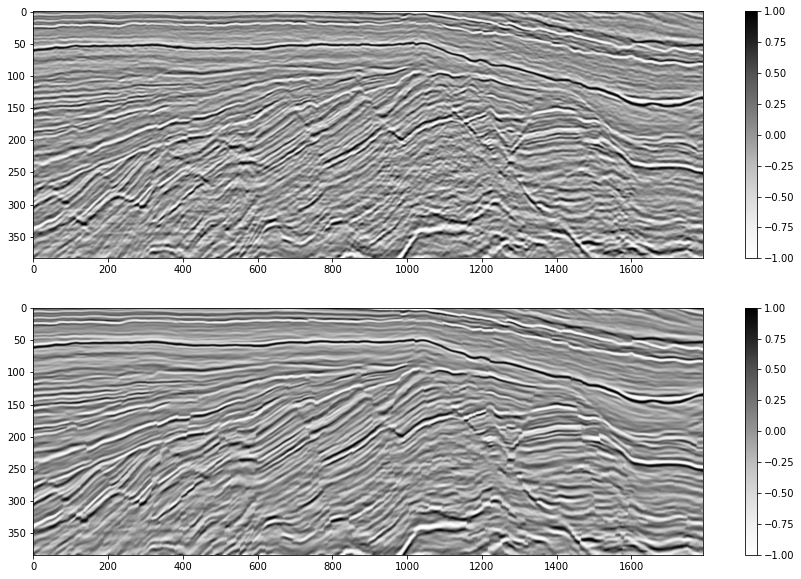

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
vs = np.percentile(normalization(seis_in), 99)
plt.imshow(normalization(seis_in).T, vmin=-vs, vmax=vs, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar()
plt.subplot(212)
ve = np.percentile(normalization(eps_out), 99)
plt.imshow(normalization(eps_out).T, vmin=-ve, vmax=ve, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar();

In [16]:
SIZE = 128

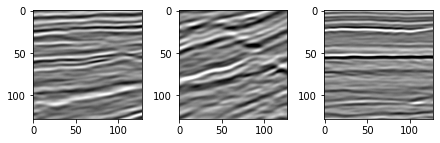

In [17]:
#Displaying images with noise
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    plt.imshow(noisy_train[i].reshape(SIZE, SIZE).T, cmap="binary")
plt.show()

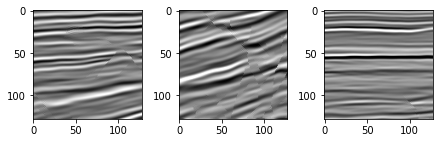

In [18]:
#Displaying clean images
plt.figure(figsize=(10, 2))
for i in range(1,4):
    ax = plt.subplot(1, 4, i)
    plt.imshow(clean_train[i].reshape(SIZE, SIZE).T, cmap="binary")
plt.show()


In [25]:
X_train, X_test, y_train, y_test = train_test_split(noisy_train, clean_train, 
                                                    test_size = 0.20, random_state = 0)

In [26]:
X_train = X_train.reshape(X_train.shape[0], 128 ,128, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 128,1)

X_train.shape

(33, 128, 128, 1)

In [19]:
def get_encoder(shape = (128, 128, 1)):

    ''' Generate Encoder model. '''
    
    encoder = Sequential()

    encoder.add(layers.Input(shape = shape))
    
    encoder.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(0.2))
    encoder.add(layers.MaxPool2D())

    encoder.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'valid'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(0.2))
    encoder.add(layers.MaxPool2D())

    encoder.add(layers.Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'valid'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.LeakyReLU(0.2))
    
    encoder.add(layers.Reshape((tf.math.reduce_prod(encoder.output.shape[1:]).numpy(),)))
    
    return encoder

In [20]:
encoder = get_encoder(shape = (128, 128, 1))

In [21]:
def get_decoder(shape_source = encoder):
    
    ''' Generate Decoder model. '''
    
    decoder = Sequential()

    decoder.add(layers.Input(shape = tuple(shape_source.output.shape[1:])))
    decoder.add(layers.Reshape(tuple(shape_source.layers[-2].output.shape[1:])))

    decoder.add(layers.Conv2DTranspose(filters = 1024, kernel_size = (3, 3), padding = 'valid'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.LeakyReLU(0.2))
    decoder.add(layers.UpSampling2D())

    decoder.add(layers.Conv2DTranspose(filters = 256, kernel_size = (3, 3), padding = 'same'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.LeakyReLU(0.2))
    decoder.add(layers.UpSampling2D())

    decoder.add(layers.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = 'valid'))
    decoder.add(layers.BatchNormalization())
    decoder.add(layers.LeakyReLU(0.2))

    decoder.add(layers.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = 'valid', activation = 'sigmoid'))
    
    return decoder

In [22]:
### Finalize the model via Functional API

encoder = get_encoder(shape = (128, 128, 1))
decoder = get_decoder(shape_source = encoder)

final_output = decoder(encoder.output)

model = Model(encoder.input, final_output)

In [23]:
### Instantiate training objects and hyperparameters
criterion = tf.losses.MeanSquaredError()
opt = Adam(learning_rate = 3e-6, beta_1 = 0.99, beta_2 = 0.999)
model.compile(optimizer=opt, loss=criterion, metrics=['accuracy'])

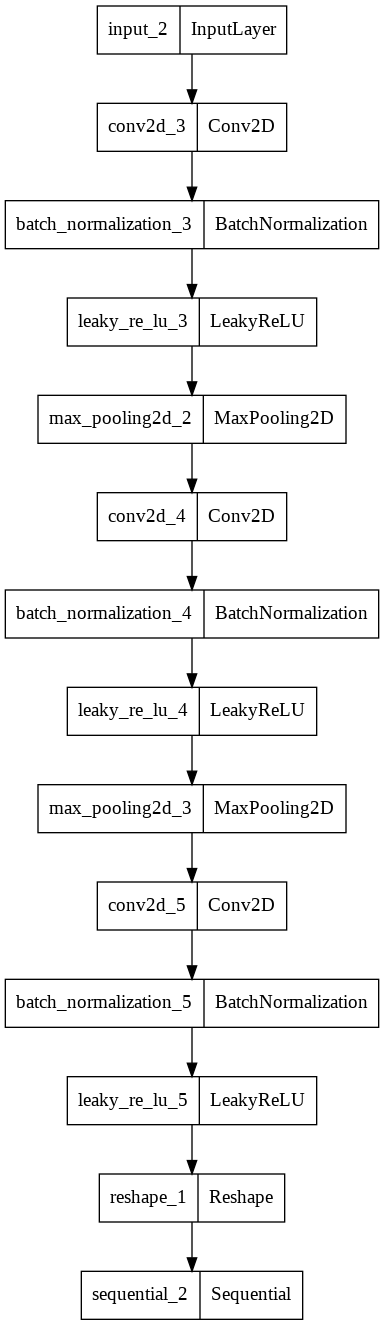

In [24]:
plot_model(model)

In [27]:
model.fit(X_train, y_train, epochs=1000, batch_size=1, verbose = 1,
          validation_split = 0.2)

Epoch 1/1000
26/26 [==============================] - 13s 61ms/step - loss: 0.3382 - accuracy: 0.0078 - val_loss: 0.4071 - val_accuracy: 0.0211
Epoch 2/1000
26/26 [==============================] - 1s 48ms/step - loss: 0.3281 - accuracy: 0.0081 - val_loss: 0.4080 - val_accuracy: 0.0212
Epoch 3/1000
26/26 [==============================] - 1s 46ms/step - loss: 0.3260 - accuracy: 0.0082 - val_loss: 0.4086 - val_accuracy: 0.0211
Epoch 4/1000
26/26 [==============================] - 1s 46ms/step - loss: 0.3248 - accuracy: 0.0082 - val_loss: 0.4090 - val_accuracy: 0.0212
Epoch 5/1000
26/26 [==============================] - 1s 46ms/step - loss: 0.3239 - accuracy: 0.0082 - val_loss: 0.4093 - val_accuracy: 0.0212
Epoch 6/1000
26/26 [==============================] - 1s 46ms/step - loss: 0.3232 - accuracy: 0.0082 - val_loss: 0.4096 - val_accuracy: 0.0211
Epoch 7/1000
26/26 [==============================] - 1s 47ms/step - loss: 0.3227 - accuracy: 0.0082 - val_loss: 0.4100 - val_accuracy: 0.021

In [28]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

1/1 [==============================] - 2s 2s/step - loss: 0.2441 - accuracy: 0.0120
Test_Accuracy: 1.20%


In [39]:
model.evaluate(np.array(X_test), np.array(y_test))

1/1 [==============================] - 0s 154ms/step - loss: 0.2441 - accuracy: 0.0120


[0.24407190084457397, 0.0120103619992733]

In [40]:
model.evaluate(np.array(X_train), np.array(y_train))

2/2 [==============================] - 4s 18ms/step - loss: 0.2313 - accuracy: 0.0108


[0.23133181035518646, 0.010840213857591152]

1/1 [==============================] - 0s 220ms/step


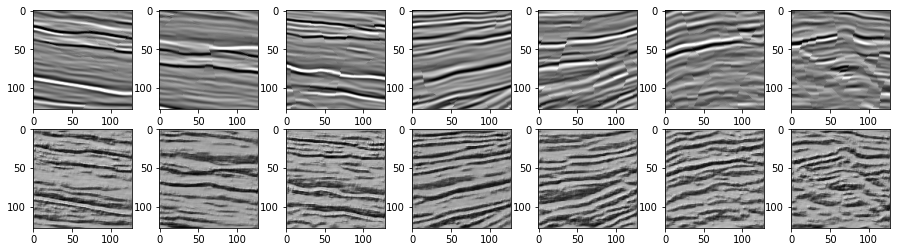

In [29]:
no_noise_img = model.predict(X_test)
plt.figure(figsize=(20, 4))
for i in range(7):
    # display original
    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(y_test[i].reshape(SIZE,SIZE).T, cmap="gray")
    
    # display reconstructed (after noise removed) image
    ax = plt.subplot(2, 9, 9+i+ 1)
    plt.imshow(no_noise_img[i].reshape(SIZE,SIZE).T, cmap="gray")
plt.show();


In [30]:
seis_patches.shape

(14, 3, 128, 128)

In [31]:
predicted_patches = []
for i in range(seis_patches.shape[0]):
  for j in range(seis_patches.shape[1]):
    single_patch = normalization(seis_patches)[i,j,:,:]
    # print(single_patch.shape)
    # single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
    # single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
    single_patch_prediction = model.predict(single_patch.reshape(1, 128, 128, 1))
    # single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
    predicted_patches.append(single_patch_prediction)

1/1 [==============================] - 0s 19ms/step


In [32]:
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(42, 1, 128, 128, 1)


In [33]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (seis_patches.shape[0], seis_patches.shape[1], seis_patches.shape[2],
                                         seis_patches.shape[3]))
print(predicted_patches_reshaped.shape)

(14, 3, 128, 128)


In [34]:
reconstructed_seismic = unpatchify(predicted_patches_reshaped, seis_in.shape)
print(reconstructed_seismic.shape)

(1792, 384)


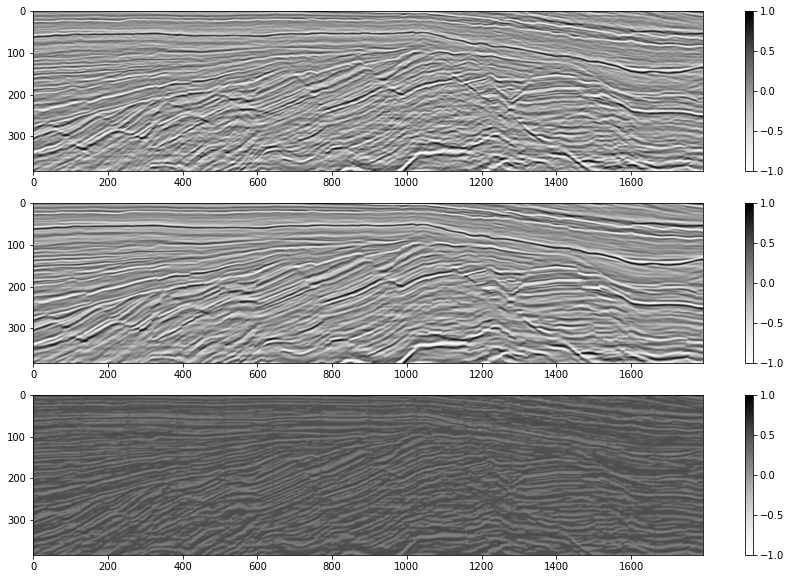

In [38]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
# vs = np.percentile(normalization(seis_in), 99)
plt.imshow(normalization(seis_in).T, vmin=-1, vmax=1, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar()
plt.subplot(312)
# ve = np.percentile(normalization(eps_out), 99)
plt.imshow(normalization(eps_out).T, vmin=-1, vmax=1, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar()
plt.subplot(313)
# vp = np.percentile(reconstructed_seismic, 99)
plt.imshow(reconstructed_seismic.T, vmin=-1, vmax=1, cmap='Greys', aspect="auto", interpolation="bicubic")
plt.colorbar();
